<a href="https://colab.research.google.com/github/aoi-hill/DCGan/blob/main/Condition_DCGan_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
device = torch.device('cuda:0')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim*8, kernel_size=4, stride=1, padding=0),
            self.make_gen_block(hidden_dim*8, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim * 2, im_chan, kernel_size=4, stride=2, padding=1, final_layer=True)
            #self.make_gen_block(hidden_dim, im_chan, kernel_size=4, stride=2, padding=1, final_layer=True),
        )

    def make_gen_block(self, input_dim, output_dim, kernel_size=3, stride=2, padding=0, final_layer=False):
        if not final_layer:
            return(nn.Sequential(
                nn.ConvTranspose2d(input_dim, output_dim, kernel_size, stride, padding),
                nn.BatchNorm2d(output_dim),
                nn.ReLU(inplace=True)
            ))
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_dim, output_dim, kernel_size, stride, padding),
                nn.Tanh())

    def forward(self, noise):
        x = noise.view(len(noise),self.input_dim,1,1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    return torch.randn(n_samples,input_dim).to(device)

  

cifar10_shape = (3,32,32)
gen_inp = z_dim + 10
gen1 = Generator(gen_inp,3).to(device)
noise = get_noise(batch_size,z_dim,device)
one_hot = get_one_hot_labels(labels.to(device), 10)
gen_inp = combine_vectors(noise,one_hot)
print(gen1(gen_inp).shape)

In [24]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim, begin=True),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim*2, hidden_dim * 4),
            self.make_disc_block(hidden_dim*4, 1, final_layer=True)
            #self.make_disc_block(hidden_dim*8, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False, begin=False):

        if not final_layer and not begin:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        elif not final_layer:
             return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride,padding, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size = 4, stride = 1 , padding= 0 , bias=False),
            )

    def forward(self, img):
        disc_pred = self.disc(img)
        return disc_pred.view(len(disc_pred), -1)


In [25]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    return F.one_hot(labels, n_classes)

In [26]:
def combine_vectors(x, y):
    return torch.cat((x,y),dim=1)

In [27]:
batch_size=128
n_epochs = 200
lr = 0.002
z_dim = 64
display_step = 500
criterion = nn.BCEWithLogitsLoss()
cifar10_shape = (3,32,32)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

dataloader_train = DataLoader(
    CIFAR10('/content/drive/MyDrive/Colab Notebooks/DeepLearningAI/GANs/coursera-gan-specialization-main/Data',train=True, download= True, transform = transform),
    batch_size = batch_size,
    shuffle = True
)

dataloader_test = DataLoader(
    CIFAR10('/content/drive/MyDrive/Colab Notebooks/DeepLearningAI/GANs/coursera-gan-specialization-main/Data',train=False, download= True, transform = transform),
    batch_size = batch_size,
    shuffle = True
)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
def get_input_dimensions(z_dim, CIFAR10_shape, n_classes):
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = CIFAR10_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [29]:
gen_inp1, disc_inp1 = get_input_dimensions(z_dim, cifar10_shape, 10)

gen = Generator(gen_inp1,3).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr)
disc = Discriminator(disc_inp1).to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr)

def weights_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight,0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/391 [00:00<?, ?it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


  0%|          | 0/391 [00:00<?, ?it/s]

Step 500: Generator loss: 13.060580848693847, discriminator loss: 2.3196519584871566e-06


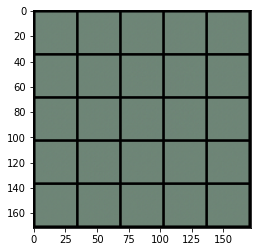

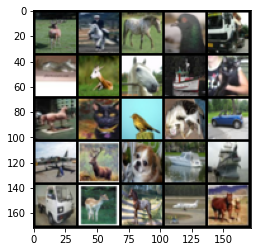

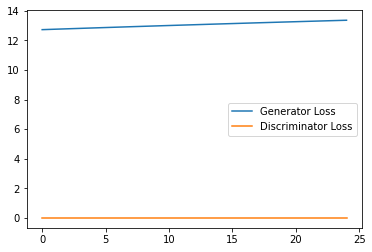

  0%|          | 0/391 [00:00<?, ?it/s]

Step 1000: Generator loss: 13.667506160736083, discriminator loss: 1.2631342366375974e-06


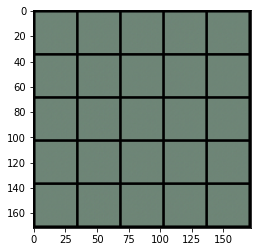

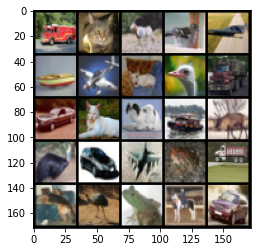

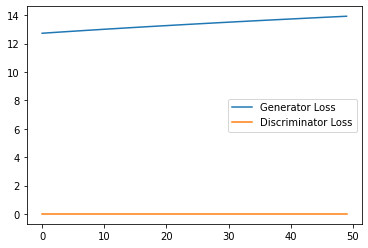

  0%|          | 0/391 [00:00<?, ?it/s]

Step 1500: Generator loss: 14.19242014312744, discriminator loss: 7.4543940672811e-07


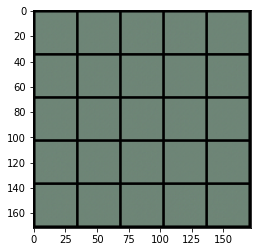

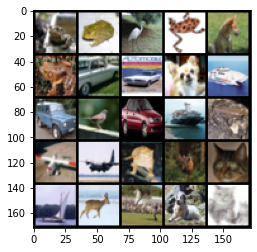

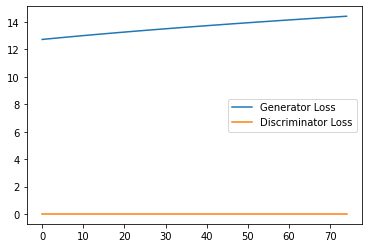

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Step 2000: Generator loss: 14.663383531570435, discriminator loss: 4.611236027471932e-07


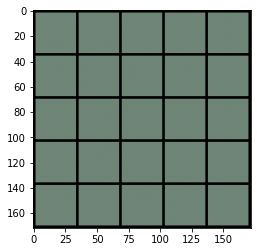

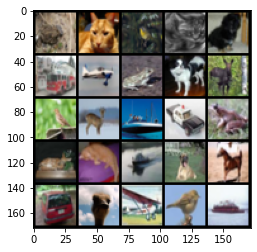

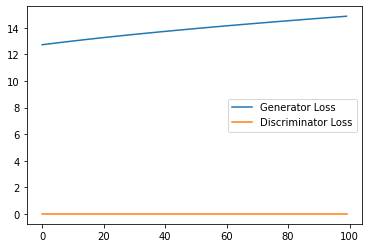

  0%|          | 0/391 [00:00<?, ?it/s]

Step 2500: Generator loss: 15.09668074798584, discriminator loss: 2.979108489284954e-07


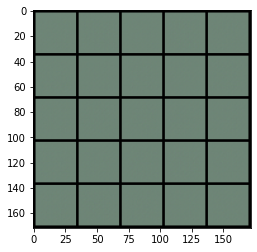

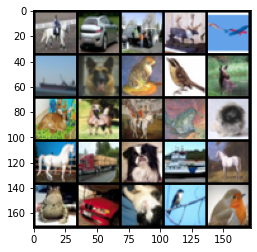

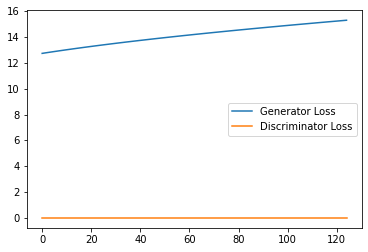

  0%|          | 0/391 [00:00<?, ?it/s]

Step 3000: Generator loss: 15.50258396911621, discriminator loss: 1.9843276891151618e-07


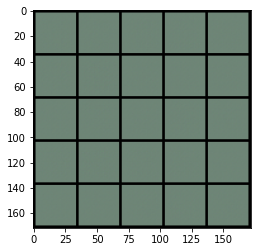

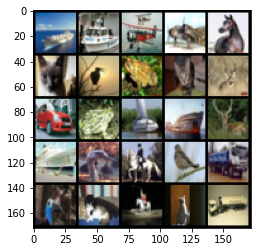

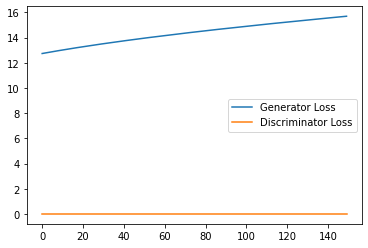

  0%|          | 0/391 [00:00<?, ?it/s]

Step 3500: Generator loss: 15.887516878128052, discriminator loss: 1.3114994436591587e-07


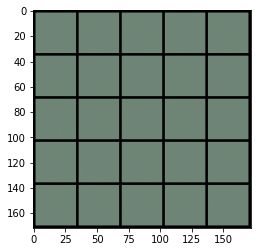

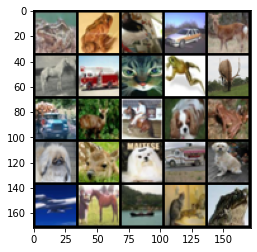

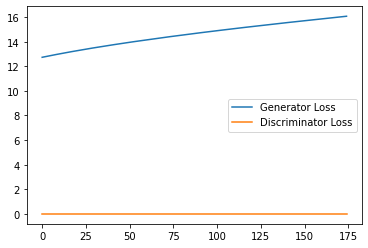

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Step 4000: Generator loss: 16.262531314849852, discriminator loss: 1.1384299509131779e-07


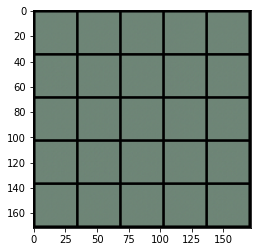

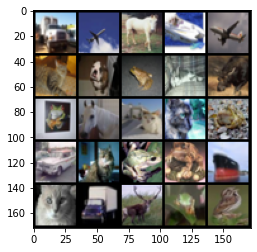

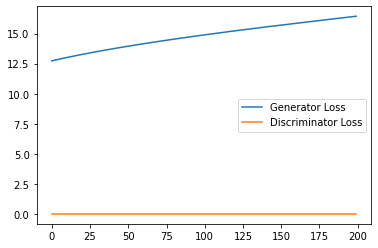

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    for data,labels in tqdm(dataloader_train):
        cur_batch_size = data.shape[0]

        data = data.to(device)
        noise = get_noise(cur_batch_size,z_dim,device)
        one_hot = get_one_hot_labels(labels.to(device), 10)
        #print(noise.shape,one_hot.shape)
        gen_inp = combine_vectors(noise,one_hot)

        image_one_hot = one_hot[:,:,None,None].repeat(1,1,cifar10_shape[1],cifar10_shape[2])
        
        disc_opt.zero_grad()

        gen_out = gen(gen_inp)
        disc_inp_fake = combine_vectors(gen_out.detach(), image_one_hot)
        disc_inp_real = combine_vectors(data, image_one_hot)
        disc_fake_pred = disc(disc_inp_fake)
        disc_real_pred = disc(disc_inp_real)
        disc_out = torch.cat((disc_fake_pred,disc_real_pred),dim=1)
        actual_labels = torch.cat((torch.zeros_like(disc_fake_pred),torch.ones_like(disc_real_pred)),dim=1)
        disc_loss = criterion(disc_out,actual_labels)

        disc_fake_loss = criterion(disc_out,actual_labels)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        discriminator_losses += [disc_loss.item()]

        gen_opt.zero_grad()

        disc_fake_pred = disc(disc_inp_fake)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        generator_losses += [gen_loss.item()]


        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(gen_out)
            show_tensor_images(data)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

        
